In [8]:
import deepcompton
import os
import numpy as np
import matplotlib.pyplot as plt
print(os.getcwd())

data_dir = "../save_Compton"
if not os.path.exists(data_dir):
    print("Could not find data directory {}".format(data_dir))

/home/aschulz/Documents/python/astroinfo2021/compton-hackathon/DeepIntegralCompton/examples


In [9]:
# instrument caracteristics
z_isgri = 0.
z_picsit = -8.68

In [10]:
# first we need to create the dataset used for training and testing
from deepcompton.cones import make_cone_density
def make_dataset(datadir, max_n = 1000):
    y,x=[],[]
    for f in os.listdir(datadir):
        _,theta,_,phi=f.replace(".npy","").split("_")
        data = make_cone_density(theta, phi, z_isgri, z_picsit, datadir=datadir, progress=False)
        if data is not None:
            y.append([float(theta),float(phi)])
            x.append(data.reshape(180,45,1))
        if len(y)==max_n:
            break
        print(len(y))
    return np.array(x),np.array(y)
# pickled data
pkl_filename = "../cone_density_data_full_rand.pkl"
if os.path.exists(pkl_filename):
    import pickle as pkl
    fdata=pkl.load(open(pkl_filename,"rb"))
    x=[e[1] for e in fdata]
    y=[e[0] for e in fdata]
    def clean_pkl_data(x,y):
        a,b=[],[]
        for i in range(len(x)):
            if x[i] is not None:
                a.append(x[i].reshape(180,45,1))
                b.append(np.array([float(y[i][0]),float(y[i][1])]))
        return np.array(a),np.array(b)
    x,y = clean_pkl_data(x,y)
    
else:
    x,y = make_dataset(data_dir)
    pkl.dump((x,y),open(pkl_filename,"wb"))

from sklearn.utils import shuffle
x, y = shuffle(x,y)
x, y = x[:10000], y[:10000]
print(x.shape, y.shape)
y *= np.pi / 180.

import gc
gc.collect()

(10000, 180, 45, 1) (10000, 2)


0

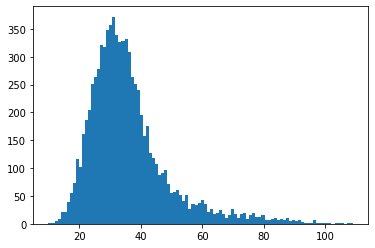

In [11]:
# plot the distribution of the data
plt.figure()
plt.hist(x[0].flatten(),bins=100)
plt.show()

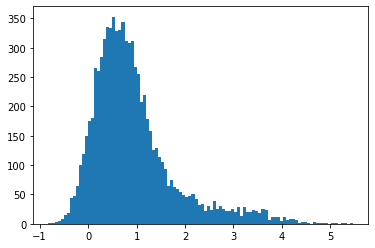

In [12]:
# normalize the data
from sklearn.preprocessing import scale
flat_x=[]
for i in range(x.shape[0]):
    flat_x.append(x[i].flatten())
flat_x=np.array(flat_x)

flat_x = scale(flat_x)

new_x = [flat_x[i].reshape(180,45,1) for i in range(flat_x.shape[0])]
new_x = np.array(new_x)
plt.figure()
plt.hist(new_x[0].flatten(),bins=100)
plt.show()

In [13]:
#from deepcompton.vizualisation import plot_backprojected
#plot_backprojected(y[0,0],y[0,1], x[0])
gc.collect()

17522

In [14]:
# creating the train and test data
from sklearn.model_selection import train_test_split
import tensorflow as tf
x_train,x_test, y_train,y_test = train_test_split(new_x, y, shuffle=True)

y_train,y_test = np.array(y_train), np.array(y_test)
x_train,x_test = np.array(x_train), np.array(x_test)
print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)

# convert to tensorflow tensors
y_train = tf.convert_to_tensor(y_train)
x_train = tf.convert_to_tensor(x_train)
#y_test= tf.convert_to_tensor(y_test)
#x_test= tf.convert_to_tensor(x_test)
print("Train data : {} {}".format(x_train.shape, y_train.shape))
print("Test data  : {} {}".format(x_test.shape, y_test.shape))


(7500, 180, 45, 1) (7500, 2) (2500, 180, 45, 1) (2500, 2)
Train data : (7500, 180, 45, 1) (7500, 2)
Test data  : (2500, 180, 45, 1) (2500, 2)


In [15]:
# definition of a first convolutional model
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPool2D, BatchNormalization, Dense, Flatten
def get_model():
    model = tf.keras.Sequential()
    model.add(Conv2D(32,3,input_shape=(180,45,1), activation="elu"))
    model.add(MaxPool2D((3,3)))
    model.add(Conv2D(64,3, activation="elu"))
    model.add(MaxPool2D((3,3)))
    model.add(Conv2D(128,3, activation="elu"))
    #model.add(Conv2D(64,3, activation="elu"))
    model.add(BatchNormalization())
    model.add(Flatten())
    model.add(Dense(512,activation="elu"))
    model.add(BatchNormalization())
    #model.add(Dense(128,activation="relu"))
    #model.add(BatchNormalization())
    model.add(Dense(2, activation=None))
    return model

In [16]:
from deepcompton.utils import angular_separation
def angular_loss(y_true, y_pred):
    return -1. * (tf.math.sin(y_true[:,0])*tf.math.sin(y_pred[:,0])*
                  tf.math.cos(y_true[:,1]-y_pred[:,1])+
                  tf.math.cos(y_pred[:,0])*tf.math.cos(y_true[:,0]))
    

In [17]:
# create the model
model = get_model()

In [18]:
epochs = 1000
batch_size = 256

name = "density_cnn_1_aloss_3layer_rand_1e-4"

callbacks = [
    #keras.callbacks.ModelCheckpoint("save_at_{epoch}.h5"),
    tf.keras.callbacks.TensorBoard('./logs/{}'.format(name)),
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10),
    tf.keras.callbacks.ModelCheckpoint("./models/{}.hdf5".format(name), monitor='val_loss'),
]

def angle(yt,yp):
    return tf.math.acos(-1.*angular_loss(yt,yp)) * 180. / np.pi

model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4),
    loss=angular_loss,
    metrics=[angular_loss,"mean_squared_error",angle],
    #loss=angular_loss,
    #metrics=[angular_loss],
)

In [1]:
if os.path.exists("./models/{}.hdf5".format(name)):
    print("Loading weights")
    model.load_weights("./models/{}.hdf5".format(name))


NameError: name 'os' is not defined

In [ ]:


model.fit(
    x_train, y_train, 
    #steps_per_epoch=epochs,
    batch_size=batch_size, 
    epochs=epochs, 
    callbacks=callbacks, 
    validation_split = 0.2,
)

Epoch 1/1000
24/24 [==============================] - 17s 681ms/step - loss: -0.0475 - angular_loss: -0.0475 - mean_squared_error: 64.0087 - angle: 86.7811 - val_loss: -0.2220 - val_angular_loss: -0.2220 - val_mean_squared_error: 14.5466 - val_angle: 74.9266
Epoch 2/1000
24/24 [==============================] - 19s 797ms/step - loss: -0.0854 - angular_loss: -0.0854 - mean_squared_error: 104.5027 - angle: 84.3831 - val_loss: 0.0718 - val_angular_loss: 0.0718 - val_mean_squared_error: 18.9506 - val_angle: 94.9320
Epoch 3/1000
24/24 [==============================] - 19s 783ms/step - loss: -0.1727 - angular_loss: -0.1727 - mean_squared_error: 100.2173 - angle: 78.2981 - val_loss: 0.1077 - val_angular_loss: 0.1077 - val_mean_squared_error: 20.2722 - val_angle: 97.4210
Epoch 4/1000
24/24 [==============================] - 19s 783ms/step - loss: -0.2292 - angular_loss: -0.2292 - mean_squared_error: 81.0645 - angle: 74.3607 - val_loss: 0.1291 - val_angular_loss: 0.1291 - val_mean_squared_erro

In [16]:
score = model.evaluate(x_test, y_test, verbose=0)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

Test loss: -0.932431161403656
Test accuracy: -0.932431161403656


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


[[35.511383  0.      ]]
[32.  8.]


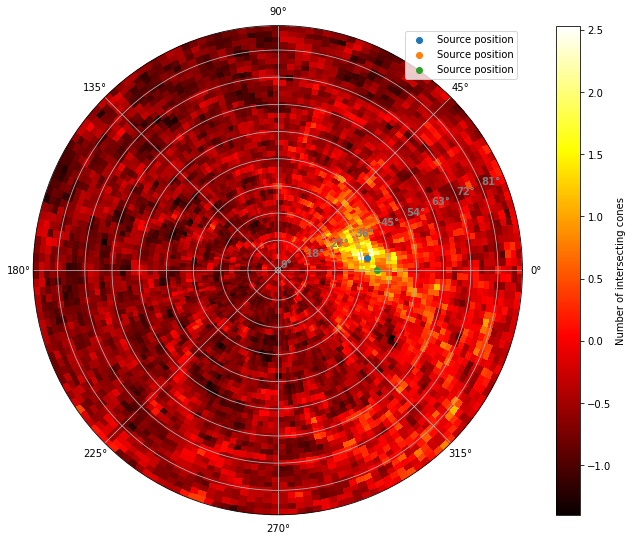

In [17]:
from deepcompton.vizualisation import plot_backprojected,plot_source_pos
i=2

actual = np.radians(np.linspace(0,360, 180))
expected = np.arange(0,90,2)
r_g, theta_g = np.meshgrid(expected, actual)
ax = plot_backprojected(theta_g, r_g, x_test[i].reshape(180,45))
ax = plot_source_pos(y_test[i,0]*180./np.pi, y_test[i,1], ax=ax)
pred = model(tf.reshape(x_test[i],[1,180,45,1]))
print(pred.numpy() * 180. / np.pi)
print(y_test[i] *180 / np.pi)
ax = plot_source_pos(pred[0,0] * 180. / np.pi, pred[0,1], ax=ax)
ax = plot_source_pos(pred[0,0] * 180. / np.pi, pred[0,1], ax=ax)


Mean angular separation : 17.75246093998496


Text(0.5, 0, 'Angular separation (deg)')

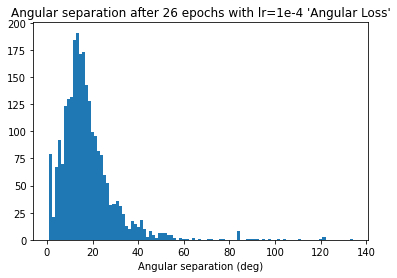

In [19]:
pred = model(x_test).numpy()
from deepcompton.utils import angular_separation
# compute angular separation
y_real_rad = y_test
y_pred_rad = pred

angular_seps=angular_separation(y_real_rad[:,0],y_real_rad[:,1],
                               y_pred_rad[:,0],y_pred_rad[:,1]) * 180. / np.pi
angular_seps = np.array(angular_seps)
plt.figure()
plt.hist(angular_seps, bins=100)
print("Mean angular separation : {}".format(np.mean(angular_seps)))
plt.title("Angular separation after 26 epochs with lr=1e-4 'Angular Loss'")
plt.xlabel("Angular separation (deg)")